# Import Libraries


In [ ]:
import logging
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import wandb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import IPython

In [ ]:
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load Data


In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()


print(f"X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")
print(f"X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")

X_train.shape = (50000, 32, 32, 3), y_train.shape = (50000, 1)
X_test.shape = (10000, 32, 32, 3), y_test.shape = (10000, 1)


In [ ]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [ ]:
images = np.vstack([X_train, X_test])
labels = np.vstack([y_train, y_test])

print(f"images.shape = {images.shape}")
print(f"labels.shape = {labels.shape}")

print('class distribution')
pd.Series([class_names[i] for i in labels.flatten()]).value_counts()

images.shape = (60000, 32, 32, 3)
labels.shape = (60000, 1)
class distribution


frog          6000
truck         6000
deer          6000
automobile    6000
bird          6000
horse         6000
ship          6000
cat           6000
dog           6000
airplane      6000
dtype: int64

## Functions and Classes


In [ ]:
from keras.utils import plot_model


In [ ]:
# creates convolutional block
DOWNSAMPLE_COUNT = 0


def conv_block(
    filters,
    kernel_size=3,
    stride=2,
    padding="same",
    activation=keras.layers.LeakyReLU(alpha=0.2),
    use_bn=False,
    use_dropout=False,
    dropout_rate=0.4,
):
    global DOWNSAMPLE_COUNT

    model = keras.Sequential(name=f"downsample_conv_block_{DOWNSAMPLE_COUNT}")
    if use_bn:
        model.add(keras.layers.BatchNormalization())
    if use_dropout:
        model.add(keras.layers.Dropout(dropout_rate))

    model.add(
        keras.layers.Conv2D(
            filters,
            kernel_size=kernel_size,
            strides=stride,
            padding=padding,
            activation=activation,
        )
    )

    DOWNSAMPLE_COUNT += 1
    return model

In [ ]:
# creates upsample and convolutional block
UPSAMPLE_COUNT = 0


def conv_upsample_block(
    filters,
    kernel_size=3,
    padding="same",
    activation=keras.layers.LeakyReLU(alpha=0.2),
    use_bn=False,
    use_dropout=False,
    dropout_rate=0.4,
):
    global UPSAMPLE_COUNT

    model = keras.Sequential(name=f"upsample_conv_block_{UPSAMPLE_COUNT}")
    if use_bn:
        model.add(keras.layers.BatchNormalization())
    if use_dropout:
        model.add(keras.layers.Dropout(dropout_rate))
    
    model.add(keras.layers.UpSampling2D())
    model.add(
        keras.layers.Conv2D(
            filters,
            kernel_size=kernel_size,
            padding=padding,
            activation=activation,
        )
    )

    UPSAMPLE_COUNT += 1
    return model

In [ ]:
# creates transposed concolutional block
TRANSPOSE_COUNT = 0


def conv_transpose_block(
    filters,
    kernel_size=3,
    stride=2,
    padding="same",
    activation=keras.layers.LeakyReLU(alpha=0.2),
    use_bn=False,
    use_dropout=False,
    dropout_rate=0.4,
):
    global TRANSPOSE_COUNT

    model = keras.Sequential(name=f"transpose_conv_block_{TRANSPOSE_COUNT}")
    if use_bn:
        model.add(keras.layers.BatchNormalization())
    if use_dropout:
        model.add(keras.layers.Dropout(dropout_rate))

    model.add(
        keras.layers.Conv2DTranspose(
            filters,
            kernel_size=kernel_size,
            strides=stride,
            padding=padding,
            activation=activation,
        )
    )

    TRANSPOSE_COUNT += 1
    return model

In [ ]:
# base GAN class
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(
        self,
        d_optimizer,
        g_optimizer,
        loss_fn,
        metrics=["accuracy"],
    ):
        super(GAN, self).compile()
        self.discriminator.compile(optimizer=d_optimizer, loss=loss_fn, metrics=metrics)
        self.generator.compile(optimizer=g_optimizer, loss=loss_fn)

    def call(self, input, training=False):
        image = self.generator(input)
        score = self.discriminator(image)

        return image, score

In [ ]:
from wandb.keras import WandbModelCheckpoint, WandbMetricsLogger, WandbCallback

In [ ]:
# Wandb epoch model saver
# Referenced from official WandBModelCheckpoint docs:
# https://github.com/wandb/wandb/blob/latest/wandb/integration/keras/callbacks/model_checkpoint.py#L123

import glob
import os
import string
import sys

class WandbEpochModelCheckpoint(keras.callbacks.ModelCheckpoint):
    def __init__(self,
                 filepath,
                 frequency=1,
                 monitor='val_loss',
                 verbose=0,
                 save_best_only=False,
                 save_weights_only=False,
                 mode='auto',
                 options=None,
                 **kwargs):

        super().__init__(
            filepath=filepath,
            monitor=monitor,
            verbose=verbose,
            save_best_only=save_best_only,
            save_weights_only=save_weights_only,
            mode=mode,
            save_freq='epoch',
            options=options,
            **kwargs,
        )
        self.epochs_since_last_save = 0
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.frequency == 0:
            self._save_model(epoch=epoch, batch=None, logs=logs)
 
            super().on_epoch_end(epoch, logs)

            # Get filepath where the model checkpoint is saved.
            filepath = self._get_file_path(epoch=epoch, batch=None, logs=logs)
            # Log the model as artifact
            aliases = ["latest", f"epoch_{epoch}"]
            self._log_ckpt_as_artifact(filepath, aliases=aliases)

    def on_train_batch_end(self, batch, logs=None):
        pass

    #========================================

    def _log_ckpt_as_artifact(
        self, filepath, aliases
    ) -> None:
        """Log model checkpoint as  W&B Artifact."""
        try:
            assert wandb.run is not None
            model_artifact = wandb.Artifact(f"run_{wandb.run.id}_model", type="model")
            if self.save_weights_only:
                # We get three files when this is True
                model_artifact.add_file(
                    os.path.join(os.path.dirname(filepath), "checkpoint")
                )
                model_artifact.add_file(filepath + ".index")
                # In a distributed setting we get multiple shards.
                for file in glob.glob(f"{filepath}.data-*"):
                    model_artifact.add_file(file)
            elif filepath.endswith(".h5"):
                # Model saved in .h5 format thus we get one file.
                model_artifact.add_file(filepath)
            else:
                # Model saved in the SavedModel format thus we have dir.
                model_artifact.add_dir(filepath)
            wandb.log_artifact(model_artifact, aliases=aliases or [])
        except ValueError:
            # This error occurs when `save_best_only=True` and the model
            # checkpoint is not saved for that epoch/batch. Since TF/Keras
            # is giving friendly log, we can avoid clustering the stdout.
            pass

    def _check_filepath(self):
        placeholders = []
        for tup in string.Formatter().parse(self.filepath):
            if tup[1] is not None:
                placeholders.append(tup[1])
        if len(placeholders) == 0:
            wandb.termwarn(
                "When using `save_best_only`, ensure that the `filepath` argument "
                "contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. "
                "This ensures correct interpretation of the logged artifacts.",
                repeat=False,
            )

In [ ]:
# Log generator images
class GeneratorImageLogger(keras.callbacks.Callback):
    def __init__(self, latent_dim, log_freq=5, subplot_rows=10, logdir=None):
        super(GeneratorImageLogger, self).__init__()
        self.logdir = logdir
        self.log_freq = log_freq
        self.subplot_rows = subplot_rows
        self.latent_dim = latent_dim

    def _generate_img_subplot(self, images):
        no_of_cols = int(len(images) / self.subplot_rows)

        fig = plt.figure(figsize=(2 * no_of_cols, 2 * self.subplot_rows))
        for i in range(len(images)):
            ax = fig.add_subplot(self.subplot_rows, no_of_cols, i + 1)
            ax.imshow(images[i])
            ax.grid(False)
            ax.axis(False)
            ax.set_aspect("equal")

        fig.subplots_adjust(wspace=0, hspace=0)
        return fig

    def on_train_begin(self, logs=None):
        if self.logdir is not None:
            os.makedirs(self.logdir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.log_freq != 0:
            return

        latent_vectors = tf.random.normal((self.subplot_rows**2, self.latent_dim))
        generated_images = self.model.generator(latent_vectors)
        fig = self._generate_img_subplot(generated_images)

        wandb.log({"g_images": fig}, step=epoch)
        if self.logdir is not None:
            plt.savefig(f"{self.logdir}/epoch_{epoch}")
        plt.close(fig)

In [ ]:
# log FID score
# References:
# https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/
# https://wandb.ai/ayush-thakur/gan-evaluation/reports/How-to-Evaluate-GANs-using-Frechet-Inception-Distance-FID---Vmlldzo0MTAxOTI#frechet-inception-distance(fid)

from skimage.transform import resize
import scipy as sp

# ============================ #
# helper functions for embeddings
# ============================ #
inception = keras.applications.inception_v3.InceptionV3(
    include_top=False, weights="imagenet", pooling="avg"
)


def resize_images(images):
    resized = [resize(im, (100, 100, 3)) for im in images]

    return np.array(resized)


def compute_embeddings(images, inception=inception):
    images = keras.applications.inception_v3.preprocess_input(images)
    images_dataset = tf.data.Dataset.from_tensor_slices(images).batch(100)

    image_embeddings = []
    for batch in images_dataset:
        image_embeddings.extend(inception(batch))

    return np.array(image_embeddings)


fid_test_images = images[-1000:]
real_embeddings = compute_embeddings(resize_images(fid_test_images))


class FIDLogger(keras.callbacks.Callback):
    def __init__(self, latent_dim, log_freq=5):
        super(FIDLogger, self).__init__()
        global real_embeddings
        global resize_images
        global compute_embeddings

        self.log_freq = log_freq
        self.latent_dim = latent_dim

        self.resize_images = resize_images
        self.compute_embeddings = compute_embeddings
        self.real_embeddings = real_embeddings

    def calculate_frechet_distance(self, embedding1, embedding2):
        real_mu, real_sigma = embedding1.mean(axis=0), np.cov(embedding1, rowvar=False)
        gen_mu, gen_sigma = embedding2.mean(axis=0), np.cov(embedding2, rowvar=False)
        # calculate sum squared difference between means
        ssdiff = np.sum((real_mu - gen_mu) ** 2.0)
        # calculate sqrt of product between cov
        covmean = sp.linalg.sqrtm(real_sigma.dot(gen_sigma))
        # check and correct imaginary numbers from sqrt
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        fid = ssdiff + np.trace(real_sigma + gen_sigma - 2.0 * covmean)

        return fid

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.log_freq != 0:
            logs["fid"] = np.nan
            return

        latent_vectors = tf.random.normal((len(self.real_embeddings), self.latent_dim))
        latent_dataset = tf.data.Dataset.from_tensor_slices(latent_vectors).batch(100)
        gen_images = []
        for batch in latent_dataset:
            gen_images.extend(self.model.generator(batch) * 255)
        gen_embeddings = self.compute_embeddings(self.resize_images(gen_images))

        fid = self.calculate_frechet_distance(self.real_embeddings, gen_embeddings)

        logs["fid"] = fid
        wandb.log({"FID": fid}, step=epoch)
        return logs

# $ $

In [ ]:
# DCGAN with standard training loop
class DCGAN(GAN):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__(discriminator, generator, latent_dim)

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        batch_size = tf.shape(real_images)[0]

        # =============================
        # Train discriminator on real
        # =============================
        real_images = real_images / 255
        real_labels = tf.fill((batch_size, 1), 0.9)
        with tf.GradientTape() as tape:
            real_predictions = self.discriminator(real_images)
            d_real_loss = self.discriminator.compiled_loss(
                real_labels,
                real_predictions,
            )
        d_real_grads = tape.gradient(d_real_loss, self.discriminator.trainable_weights)
        self.discriminator.optimizer.apply_gradients(
            zip(d_real_grads, self.discriminator.trainable_weights)
        )

        # =============================
        # Train discriminator on fake
        # =============================
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        fake_images = self.generator(random_latent_vectors)
        fake_labels = tf.fill((batch_size, 1), 0.1)
        with tf.GradientTape() as tape:
            fake_predictions = self.discriminator(fake_images)
            d_fake_loss = self.discriminator.compiled_loss(
                fake_labels,
                fake_predictions,
            )
        d_fake_grads = tape.gradient(d_fake_loss, self.discriminator.trainable_weights)
        self.discriminator.optimizer.apply_gradients(
            zip(d_fake_grads, self.discriminator.trainable_weights)
        )

        # =============================
        # Train the generator
        # =============================
        random_latent_vectors = tf.random.normal(
            shape=(2 * batch_size, self.latent_dim)
        )
        misleading_labels = tf.ones((2 * batch_size, 1))
        with tf.GradientTape() as tape:
            misleading_predictions = self.discriminator(
                self.generator(random_latent_vectors)
            )
            g_loss = self.generator.compiled_loss(
                misleading_labels, misleading_predictions
            )
        g_grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.generator.optimizer.apply_gradients(
            zip(g_grads, self.generator.trainable_weights)
        )

        log_metrics = {"d_loss": d_real_loss + d_fake_loss, "g_loss": g_loss}
        return log_metrics

### Setup

In [ ]:
EPOCHS_TRAINED = 0
group = "laplacian"

In [ ]:
from datetime import datetime
now = int(datetime.now().strftime("%Y%m%d%H%M%S"))

In [ ]:
model_name = f"sharp_balanced"

In [ ]:
wandb.init(
    project="cifar10_gan",
    name=f"{model_name}_{now}",
    config=dict(
        architecture="minimax_transposed",
        latent_dim=128,
        disc_layers=["3x3x32", "3x3x64", "3x3x64_1", "3x3x128", "FC100"],
        gen_layers=["FC4*4*72","3x3x128", "3x3x64", "3x3x64_1", "3x3x32"],
        lr=2 * 10**-4,
    ),
    group=group,
)
# key 1b33553de266344186f717f703fad4a31800e0b3

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bevanpoh. Use `wandb login --relogin` to force relogin


### Architecture

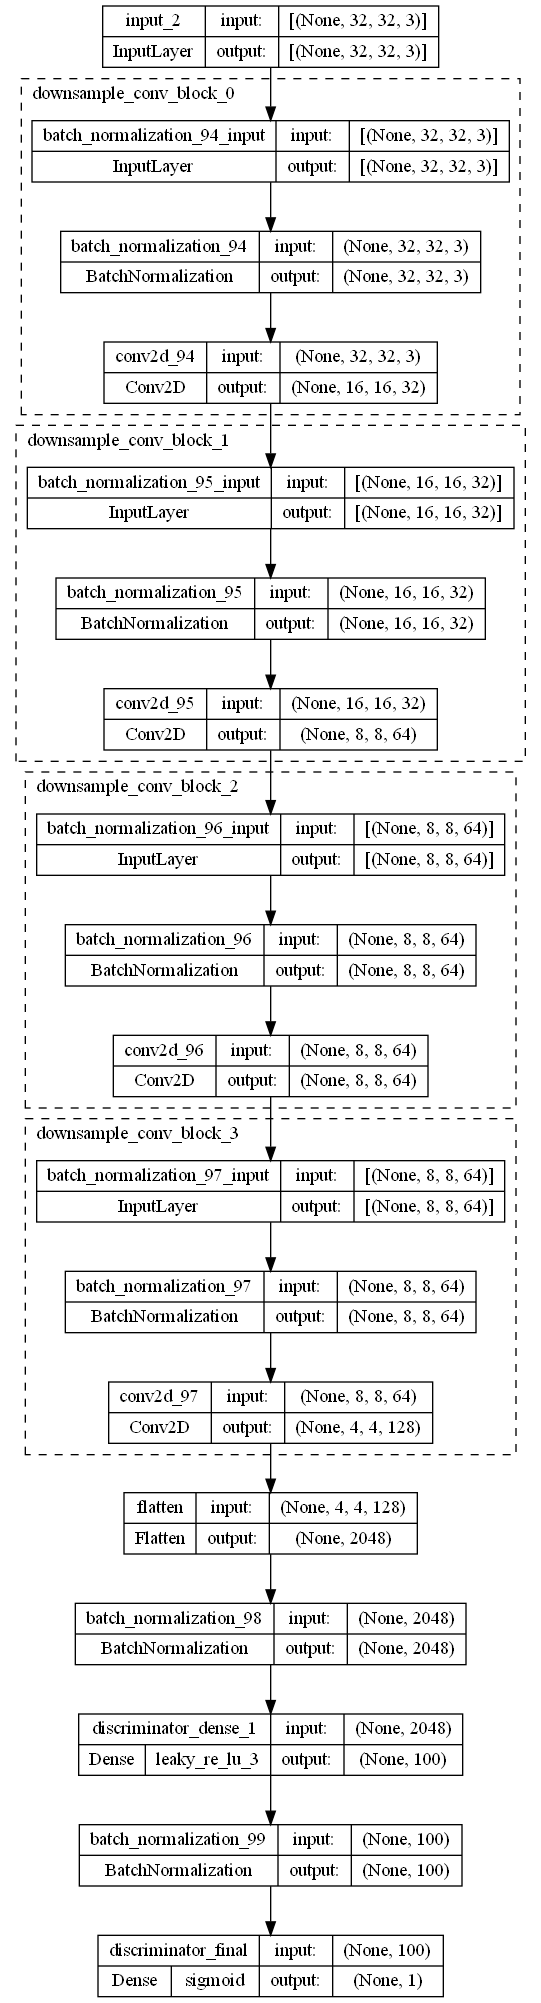

In [ ]:
discriminator = keras.Sequential(name="discriminator")
discriminator.add(keras.Input(shape=(32, 32, 3)))

discriminator.add(conv_block(32, use_bn=True))
discriminator.add(conv_block(64, use_bn=True))
discriminator.add(conv_block(64, stride=1, use_bn=True))
discriminator.add(conv_block(128, use_bn=True))
discriminator.add(keras.layers.Flatten())

discriminator.add(keras.layers.BatchNormalization())
discriminator.add(
    keras.layers.Dense(
        100, activation=keras.layers.LeakyReLU(alpha=0.2), name="discriminator_dense_1"
    )
)

discriminator.add(keras.layers.BatchNormalization())
discriminator.add(keras.layers.Dense(1, activation="sigmoid", name="discriminator_final"))

plot_model(discriminator, show_shapes=True, show_layer_activations=True, expand_nested=True)

In [ ]:
discriminator.summary(expand_nested=True)

# 344k params

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 downsample_conv_block_0 (Se  (None, 16, 16, 32)       908       
 quential)                                                       
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| batch_normalization_94 (Bat  (None, 32, 32, 3)      12        |
| chNormalization)                                              |
|                                                               |
| conv2d_94 (Conv2D)        (None, 16, 16, 32)        896       |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 downsample_conv_block_1 (Se  (None, 8, 8, 64)         18624     
 quential)                                                       
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| batch_normalization_95 (Bat  (None, 16, 16, 32)     128       |
| chNormalization)                                   

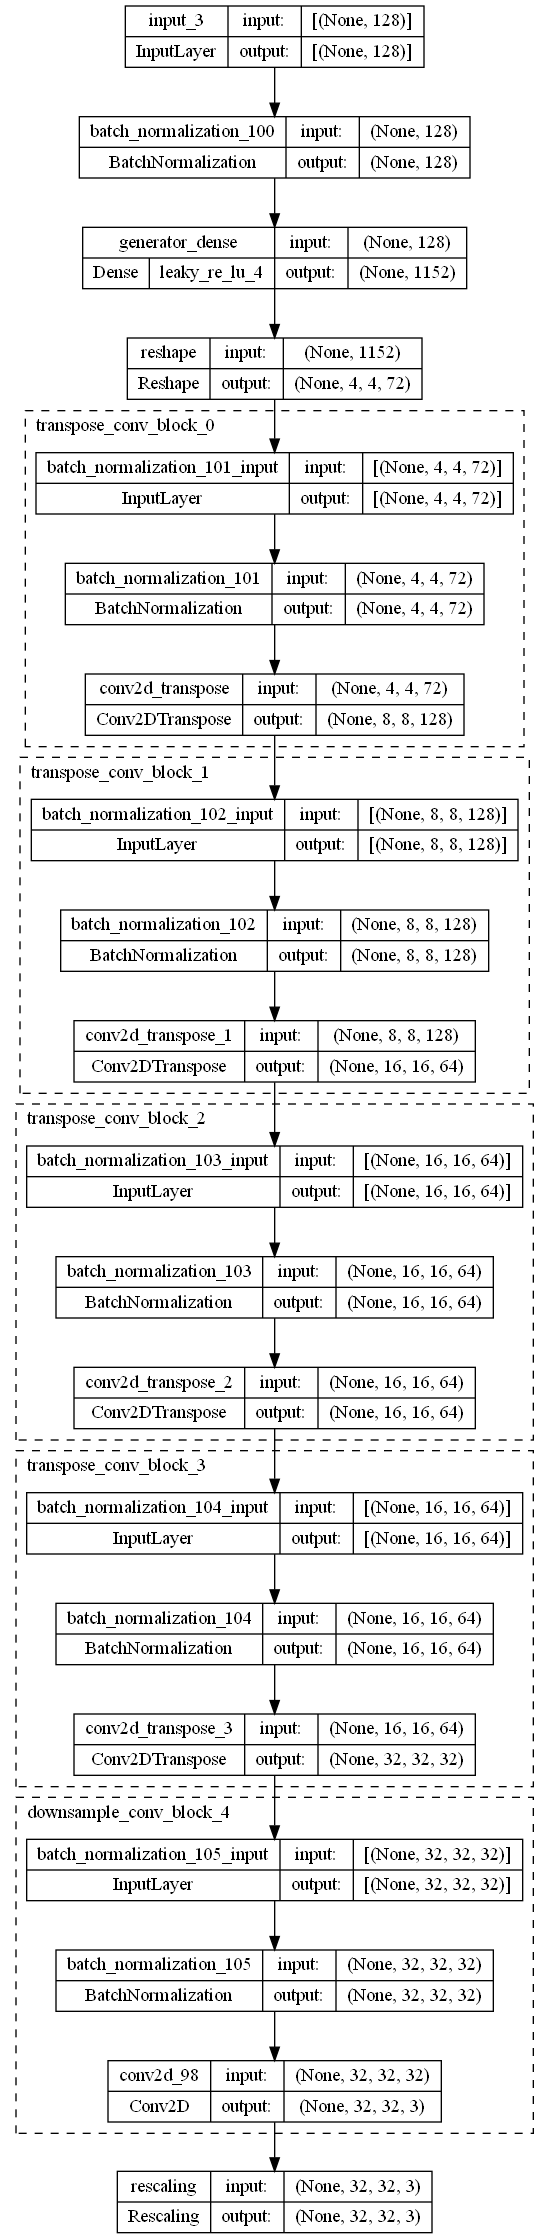

In [ ]:
generator = keras.Sequential(name="generator")
generator.add(keras.Input(shape=(wandb.config.latent_dim,)))

generator.add(keras.layers.BatchNormalization())
generator.add(
    keras.layers.Dense(
        4 * 4 * 72,
        activation=keras.layers.LeakyReLU(alpha=0.2),
        name="generator_dense",
    )
)
generator.add(keras.layers.Reshape((4, 4, 72)))

generator.add(conv_transpose_block(128, use_bn=True))
generator.add(conv_transpose_block(64, use_bn=True))
generator.add(conv_transpose_block(64, stride=1, use_bn=True))
generator.add(conv_transpose_block(32, use_bn=True))
generator.add(conv_block(3, stride=1, activation="tanh", use_bn=True))

#output range 0 to 1
generator.add(keras.layers.Rescaling(scale=0.5, offset=0.5))

plot_model(generator, show_shapes=True, show_layer_activations=True, expand_nested=True)

In [ ]:
generator.summary(expand_nested=True)

# 363k params

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_100 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                                 
 generator_dense (Dense)     (None, 1152)              148608    
                                                                 
 reshape (Reshape)           (None, 4, 4, 72)          0         
                                                                 
 transpose_conv_block_0 (Seq  (None, 8, 8, 128)        83360     
 uential)                                                        
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| batch_normalization_101 (Ba  (None, 4, 4, 72)       288       |
| tchNormalization)                                             |
|                                                        

1/1 [==============================] - 0s 157ms/step
Discriminator score: [0.30657062]


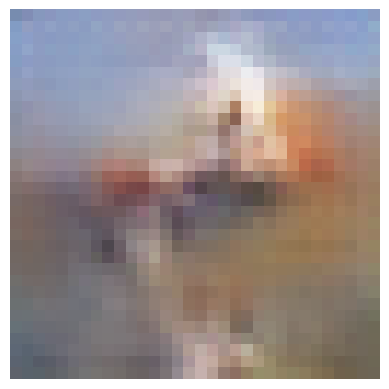

In [ ]:
gan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=wandb.config.latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=wandb.config.lr),
    g_optimizer=keras.optimizers.Adam(learning_rate=wandb.config.lr),
    loss_fn=keras.losses.BinaryCrossentropy(),
)
gan.compute_output_shape(input_shape=(None, wandb.config.latent_dim, 1))

gan.load_weights("./chkpts/balanced/150-1375.1")


random_vector = tf.random.normal(shape=(1, wandb.config.latent_dim))
generated_image = gan.generator.predict(random_vector)
discriminator_score = gan.discriminator.predict(generated_image)
print("Discriminator score:", discriminator_score[0])
plt.imshow(generated_image[0])
plt.grid(False)
plt.axis(False)
plt.show()

### Training

In [ ]:
BATCH_SIZE = 100
EPOCHS = 10

In [ ]:
history = gan.fit(
    sharpened_images,
    epochs=EPOCHS_TRAINED + EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        GeneratorImageLogger(
            logdir=f"images/{model_name}/",
            latent_dim=wandb.config.latent_dim,
            log_freq=5,
        ),
        FIDLogger(latent_dim=wandb.config.latent_dim, log_freq=5),
        WandbMetricsLogger(),
        WandbEpochModelCheckpoint(
            filepath=f"chkpts/{model_name}/" + "{epoch:03d}-{fid:.1f}",
            frequency=5,
            save_weights_only=True,
        ),
        keras.callbacks.CSVLogger(
            f"histories/{model_name}.csv", append=bool(EPOCHS_TRAINED)
        ),
    ],
    initial_epoch=EPOCHS_TRAINED,
)

history_df = pd.read_csv(f"histories/{model_name}.csv")

EPOCHS_TRAINED = len(history_df)
EPOCHS_TRAINED

Epoch 61/70
600/600 [==============================] - 38s 64ms/step - d_loss: 1.0309 - g_loss: 1.4385 - fid: nan
Epoch 62/70
600/600 [==============================] - 38s 63ms/step - d_loss: 1.0295 - g_loss: 1.4532 - fid: nan
Epoch 63/70
600/600 [==============================] - 38s 64ms/step - d_loss: 1.0294 - g_loss: 1.4515 - fid: nan
Epoch 64/70
600/600 [==============================] - 38s 64ms/step - d_loss: 1.0284 - g_loss: 1.4580 - fid: nan
Epoch 65/70
600/600 [==============================] - 54s 90ms/step - d_loss: 1.0220 - g_loss: 1.4644 - fid: 1374.1052
Epoch 66/70
600/600 [==============================] - 39s 64ms/step - d_loss: 1.0223 - g_loss: 1.4670 - fid: nan
Epoch 67/70
600/600 [==============================] - 37s 61ms/step - d_loss: 1.0186 - g_loss: 1.4768 - fid: nan
Epoch 68/70
600/600 [==============================] - 37s 61ms/step - d_loss: 1.0182 - g_loss: 1.4839 - fid: nan
Epoch 69/70
600/600 [==============================] - 38s 64ms/step - d_loss: 1.0

70

In [ ]:
wandb.finish()

FID,▂▁▂▅▅▄▄▆▅▆▅█▆▅
epoch/d_loss,▄█▆▃█▅▅▆▄▃▅▆▄▄▅▂▇▃▆▅▃▂▃▁▄▁▅▂▂▆▂▃▃▃▂▅▁▁▁▃
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/fid,▁ ▇ ▇ ▆ █ ▆ █
epoch/g_loss,▃▂▂▂▁▃▃▃▃▂▃▂▂▄▃▃▃▆▄▄▃▆▃▃▄▄▆▄▃▅▆▄▅▅▆▆▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
FID,1354.33204
epoch/d_loss,1.03129
epoch/epoch,69
epoch/fid,1354.33204
epoch/g_loss,1.68868


### Evaluation

In [ ]:
group = "laplacian"

strong_generator


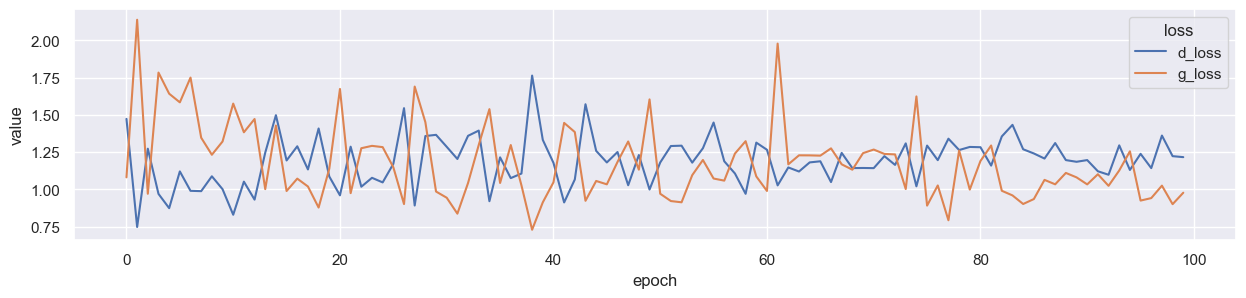

c:\Users\Bevan\anaconda3\envs\gpu_env\lib\site-packages\IPython\core\display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [ ]:
model_name = "sharp_balanced"
print(model_name)
history_df = pd.read_csv(f"histories/{model_name}.csv")

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
sns.lineplot(
    data=pd.melt(
        history_df, id_vars="epoch", value_vars=["d_loss", "g_loss"], var_name="loss"
    ),
    y="value",
    x="epoch",
    hue="loss",
    ax=ax,
)

plt.show()

wandb.login()
api = wandb.Api()
run_url = "bevanpoh/cifar10_gan"
runGroup = api.runs(
    run_url, filters={"group": group, "display_name": {"$regex": f"{model_name}_.+"}}
)
# hover over images and click top right to view images in fullscreen)
# runs are sorted in order of epochs since some runs are training continued from checkpoints
sorted_runs = sorted(runGroup, key=lambda run: run.name.split("_")[-1])

for run in sorted_runs:
    run.display(height=700)